In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import datetime as dt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster

import scipy.stats as stats
from scipy.spatial.distance import cdist
from matplotlib.patches import Circle

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 40

from IPython.display import display, Markdown
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.metrics.cluster import adjusted_rand_score

import fonction

In [2]:
data = pd.read_csv('../data/data_cleaned.csv')
df_rfm_nfd = pd.read_csv('../data/df_rfm_nfd.csv')
df_acp = pd.read_csv('../data/acp_data.csv')

In [3]:
pd.options.display.float_format = '{:,.3f}'.format

# Convertir la date
data['date_achat'] = pd.to_datetime(data['date_achat'])

# Visualiser shape, min-max date, 5 premières lignes
display(Markdown(f'**Merged DATAFRAME dimension : {data.shape}**'))
print('Min date: {}, Max date: {}'.format(data.date_achat.min(),
                                          data.date_achat.max()))
data.head()

**Merged DATAFRAME dimension : (93139, 18)**

Min date: 2016-09-04 21:15:19, Max date: 2018-09-03 09:06:57


,customer_unique_id,customer_city,customer_state,geolocation_lat,geolocation_lng,Frais_de_port,horaire_achat,date_achat,annee_mois,mois_achat,heure_achat,Note_Moyenne_Commentaire,Moy_Paiment,Facilités,Delai_Moyen_livraison,Nb_moyen_produits_par_commandes,categorie_la_plus_achetee,Total_moyen_achats
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,SP,-23.340,-46.831,12.000,6-11h,2018-05-10 10:56:27,201805,5,10.000,5.000,credit_card,8.000,7.000,1.000,home,129.900
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,SP,-23.559,-46.789,8.290,6-11h,2018-05-07 11:11:27,201805,5,11.000,4.000,credit_card,1.000,4.000,1.000,health_beauty,18.900
2,0000f46a3911fa3c0805444483337064,sao jose,SC,-27.543,-48.635,17.220,18-21h,2017-03-10 21:05:03,201703,3,21.000,3.000,credit_card,8.000,26.000,1.000,office,69.000
3,0000f6ccb0745a6a4b88665a16c9f078,belem,PA,-1.313,-48.483,17.630,18-21h,2017-10-12 20:29:41,201710,10,20.000,4.000,credit_card,4.000,21.000,1.000,electronics,25.990
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,SP,-23.506,-47.470,16.890,18-21h,2017-11-14 19:45:42,201711,11,19.000,5.000,credit_card,6.000,14.000,1.000,electronics,180.000


In [4]:
time_delta = int((data['date_achat'] .max() - data['date_achat'] .min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [5]:
# Ajout des données RFM au jeu de données
data_acp = pd.merge(df_acp,data[['customer_unique_id','date_achat']],
                  how='left',
                  left_on='customer_unique_id',
                  right_on='customer_unique_id'
                  )

In [6]:
# Obtenir les principales données temporelles de l'ensemble de données
date_first = data_acp.date_achat.min()
date_last = data_acp.date_achat.max()

# Définir les données de référence avec les informations d'UN AN
date_init = date_first + timedelta(days=40)
#date_month = date_first.dt.month

# Filter the reference dataset with time mask
timemask = data_acp.date_achat < date_init
data_init = data_acp[timemask]

print('Min date: {}, Max date: {}'.format(data_init.date_achat.min(),
                                          data_init.date_achat.max()))

# Visualiser shape, valeurs manquantes, 5 premières lignes
display(Markdown(f'**Initialized DATAFRAME dimension : {data_init.shape}**'))
data_init = data_init.set_index('customer_unique_id')
data_init.head()

Min date: 2016-09-04 21:15:19, Max date: 2016-10-10 18:09:39


**Initialized DATAFRAME dimension : (291, 10)**

,cout,insatisfaction,frequence,credit,delai_livraison,frais_livraison,categorie_maison,categorie_electronique_beaute,date_achat
customer_unique_id,,,,,,,,,
0032c76b20340da25249092a268ce66c,-0.598,0.050,-0.092,0.432,-0.096,0.364,0.017,-0.040,2016-10-06 11:32:00
01f156677184504063bd19739f924af1,3.664,-1.493,-0.673,-0.952,0.280,0.620,0.826,0.114,2016-10-10 13:57:41
0313291a6f4f16df04dcf819d88c38ef,0.440,6.227,-2.292,-0.309,2.711,-0.217,0.898,-0.042,2016-10-09 12:34:53
0636d30c77f0f9cfad81f1c9b58c791f,3.597,-0.889,-0.243,-1.400,0.024,2.358,-0.278,0.805,2016-10-08 02:18:43
0659f2d6cabae94afd4d009c6d0e07dc,2.798,6.072,-1.003,-0.230,3.179,-0.374,-0.065,-0.018,2016-10-09 11:23:21


In [7]:
#data_init['frequence'] = data_init[['frequence']].apply(np.log, axis = 1).round(3)

In [8]:
# Filter dataframe
#data_init['frequence'] = data_init[['frequence']].apply(np.log, axis = 1).round(3)
scaled_init = fonction.preprocess(data_init, var_quali=None, stdScale=False)
scaled_init.describe()

,cout,insatisfaction,frequence,credit,delai_livraison,frais_livraison,categorie_maison,categorie_electronique_beaute
count,291.000,291.000,291.000,291.000,291.000,291.000,291.000,291.000
mean,0.174,0.336,0.333,0.445,0.330,0.512,0.368,0.452
std,0.149,0.218,0.109,0.153,0.197,0.089,0.282,0.282
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.068,0.207,0.323,0.351,0.245,0.478,0.161,0.130
50%,0.135,0.238,0.336,0.482,0.329,0.515,0.313,0.480
75%,0.232,0.402,0.344,0.547,0.354,0.541,0.401,0.532
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [13]:
# Lancer Kmeans avec k clusters
kmeans=KMeans(n_clusters=5, init='k-means++', random_state=2611)
kmeans.fit(scaled_init)

# Prédire les clusters initiaux
segment_init = kmeans.labels_

# Enregistrez les centroïdes pour les futures initialisations
segment_centers = kmeans.cluster_centers_


# définir des variables
index = -1
date_lim = date_init

# Créer df pour enregistrer tous les résultats (étiquettes et scores ARI)
segment_df = pd.DataFrame()
ARI_results = pd.DataFrame()

# Itérer jusqu'à ce que nous atteignions la dernière date (max)
while date_lim < date_last:
    index +=1
    
    # Obtenir de nouvelles données filtrées
    timemask = data_acp.date_achat < date_lim
    merged_new = data_acp[timemask]

    grouped_new = fonction.groupby_unique_customer(merged_new)
    
    # Filter le dataframe
    filter_new = grouped_new.loc[:,['cout', 'insatisfaction', 'frequence',
                                     'credit', 'delai_livraison', 'frais_livraison',
                                   'categorie_maison','categorie_electronique_beaute','recence']].copy()
    
    # pre-processing
    scaled_new = fonction.preprocess(filter_new, var_quali=None, stdScale=False)
    
    # lancer Kmeans avec k clusters
    kmeans=KMeans(n_clusters=6,init='k-means++', random_state=2611)
    kmeans.fit(scaled_new)
    
    # Itérer pour la stabilité
    ARI_scores = []
    
    # Liste des clients dans la partition initiale
    list_index_init = scaled_init.index
    mask = scaled_new.index.isin(list_index_init)

    # Obtenir les nouvelles étiquettes
    segment_new = kmeans.labels_[mask]
    
    # enregistrer les labels  (pour Sankey)
    name = str(date_lim.strftime('%Y%m'))
    segment_ser = pd.Series(segment_new,
                            index=list_index_init,
                            name=f'seg_'+name)
    segment_df = pd.concat([segment_df, segment_ser.to_frame()],
                           axis=1)

    # Calculer et enregistrer le score ARI entre le segment initial et le nouveau segment
    ARI_score = adjusted_rand_score(segment_init, segment_new)
    ARI_scores.append(ARI_score)

    # Ajouter l'horodatage et les ARI_scores à ARI_results au df
    ARI_results.loc[index, 'period'] = date_lim
    ARI_results.loc[index, 'ARI_mean'] = np.mean(ARI_scores)
        
    # Augmenter la date limite de 30 jours pour la prochaine itération
    date_lim += timedelta(days=30)

# Afficher les resultats
ARI_results

,period,ARI_mean
0,2016-10-14 21:15:19,0.83
1,2016-11-13 21:15:19,0.83
2,2016-12-13 21:15:19,0.83
3,2017-01-12 21:15:19,1.00
4,2017-02-11 21:15:19,0.00
5,2017-03-13 21:15:19,0.00
6,2017-04-12 21:15:19,0.00
7,2017-05-12 21:15:19,0.00
8,2017-06-11 21:15:19,0.00
9,2017-07-11 21:15:19,0.17


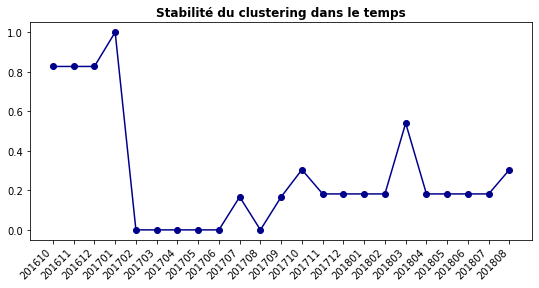

In [14]:
x = ARI_results.period.apply(lambda x: x.strftime('%Y%m'))
plt.figure(figsize=(9, 4))
plt.plot(x, ARI_results.ARI_mean, c='darkblue', marker='o')
plt.title('Stabilité du clustering dans le temps',
          fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

Sur ce plot des scores ARI obtenus, on remarque **une forte inflexion après 4 mois** sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 4 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. 

Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.